In [2]:
import os
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
import yfinance as yf

In [3]:
end_date = datetime.today().strftime('%Y-%m-%d')
spy = yf.download('SPY', start='1993-01-29', end=end_date)
cpi = pd.read_csv('cpi.csv')

[*********************100%***********************]  1 of 1 completed


In [4]:
cpi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 934 entries, 0 to 933
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   DATE      934 non-null    object 
 1   CPIAUCSL  934 non-null    float64
dtypes: float64(1), object(1)
memory usage: 14.7+ KB


In [5]:
print(spy.head(5))
print(cpi.head(5))
print(cpi.tail(5))

                Open      High       Low     Close  Adj Close   Volume
Date                                                                  
1993-01-29  43.96875  43.96875  43.75000  43.93750  24.608624  1003200
1993-02-01  43.96875  44.25000  43.96875  44.25000  24.783655   480500
1993-02-02  44.21875  44.37500  44.12500  44.34375  24.836161   201300
1993-02-03  44.40625  44.84375  44.37500  44.81250  25.098690   529400
1993-02-04  44.96875  45.09375  44.46875  45.00000  25.203712   531500
         DATE  CPIAUCSL
0  1947-01-01     21.48
1  1947-02-01     21.62
2  1947-03-01     22.00
3  1947-04-01     22.00
4  1947-05-01     21.95
           DATE  CPIAUCSL
929  2024-06-01   313.049
930  2024-07-01   313.534
931  2024-08-01   314.121
932  2024-09-01   314.686
933  2024-10-01   315.454


In [6]:
# Clean and preprocess inflation and SPY data
cpi = cpi.rename(columns={"DATE": "date", "CPIAUCSL": "cpi_value"})
cpi["date"] = pd.to_datetime(cpi["date"])
cpi["cpi_value"] = cpi["cpi_value"].astype(float).round(2)
cpi = cpi[(cpi["date"] >= "2000-01-01")]
cpi.reset_index(inplace=True, drop=True)

spy = spy.drop(columns=["Open", "High", "Low", "Close", "Volume"])
spy.reset_index(inplace=True)
spy = spy.rename(columns={"Adj Close": "close_price", "Date": "date"})
spy["date"] = pd.to_datetime(spy["date"])
spy["close_price"] = spy["close_price"].round(2)

## Calculating SPY Prices adjusted for inflation

The formula is: 

$$\text{Inflation Adjusted Price} = \text{Nominal SPY Price} \times \left(\frac{\text{Current CPI}}{\text{Historical CPI}}\right)$$

We will find the adjustment factor which is $ \frac{\text{Current CPI}}{\text{Historical CPI}} $


In [8]:
spy

,date,close_price
0,1993-01-29,24.61
1,1993-02-01,24.78
2,1993-02-02,24.84
3,1993-02-03,25.10
4,1993-02-04,25.20
...,...,...
8017,2024-12-02,603.63
8018,2024-12-03,603.91
8019,2024-12-04,607.66
8020,2024-12-05,606.66


In [9]:
cpi

,date,cpi_value
0,2000-01-01,169.30
1,2000-02-01,170.00
2,2000-03-01,171.00
3,2000-04-01,170.90
4,2000-05-01,171.20
...,...,...
293,2024-06-01,313.05
294,2024-07-01,313.53
295,2024-08-01,314.12
296,2024-09-01,314.69


In [10]:
cpi["adj_fac"] = cpi["cpi_value"] / cpi["cpi_value"].iloc[0]

date_range = pd.date_range(start=spy["date"].min(), end=spy["date"].max(), freq="D")
full_date_df = pd.DataFrame({"date": date_range})

# Merge SPY with the full date range to include all days
spy_full = full_date_df.merge(spy, on="date", how="left")

# Merge SPY data with CPI data
merged_df = spy_full.merge(cpi, on="date", how="left")

# Forward-fill missing values in both CPI and SPY data
merged_df["close_price"] = merged_df["close_price"].ffill()  # SPY closing prices
merged_df["adj_fac"] = merged_df["adj_fac"].ffill()  # Inflation adjustment factor

# Calculate real_price (inflation-adjusted SPY price)
merged_df["real_price"] = merged_df["close_price"] / merged_df["adj_fac"]

# Drop rows with any remaining missing critical values
merged_df = merged_df.dropna(subset=["close_price", "adj_fac"])

# Reset index for consistency
merged_df = merged_df.reset_index(drop=True)
merged_df = merged_df.dropna(subset=["cpi_value"])

# Display the first few rows of the merged DataFrame
print(merged_df.head())

          date  close_price  cpi_value   adj_fac  real_price
0   2000-01-01        93.92      169.3  1.000000   93.920000
31  2000-02-01        90.13      170.0  1.004135   89.758876
60  2000-03-01        88.53      171.0  1.010041   87.649877
91  2000-04-01        96.41      170.9  1.009451   95.507390
121 2000-05-01        94.28      171.2  1.011223   93.233668


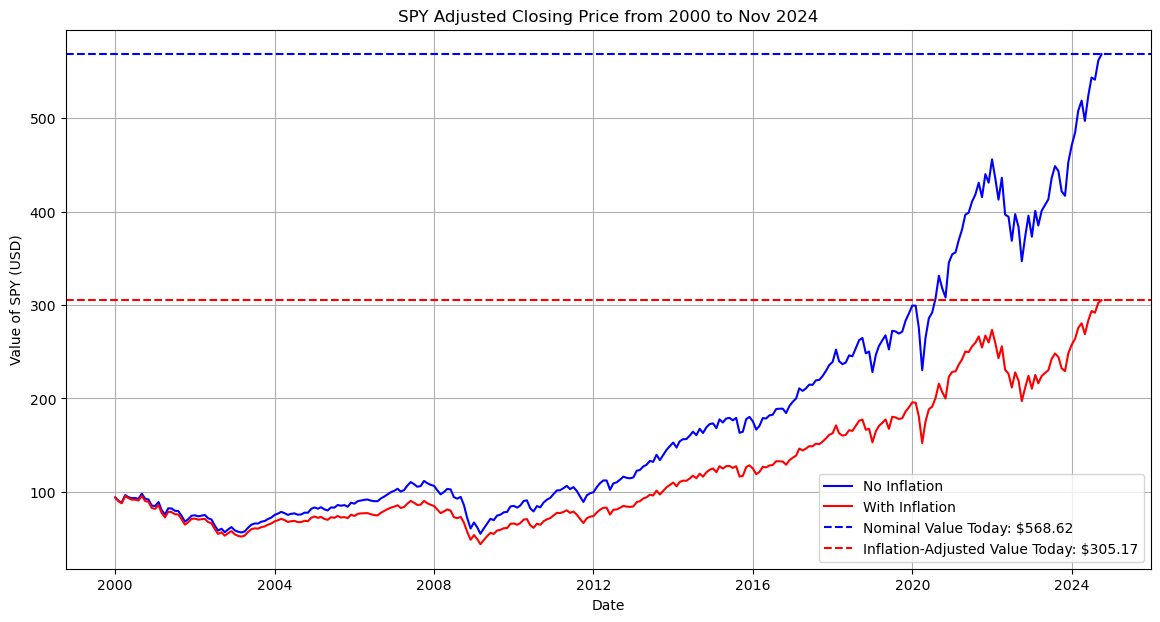

In [11]:
# Extract current values from merged_df
current_nominal_value = merged_df["close_price"].iloc[-1]
current_infl_adj_value = merged_df["real_price"].iloc[-1]

# Creating the plot
plt.figure(figsize=(14, 7))

# Plotting the SPY prices
plt.plot(merged_df["date"], merged_df["close_price"], color="blue", label="No Inflation")
plt.plot(merged_df["date"], merged_df["real_price"], color="red", label="With Inflation")

# Adding horizontal lines to highlight the current values
plt.axhline(
    y=current_nominal_value,
    color="blue",
    linestyle="--",
    linewidth=1.5,
    label=f"Nominal Value Today: ${current_nominal_value:,.2f}",
)
plt.axhline(
    y=current_infl_adj_value,
    color="red",
    linestyle="--",
    linewidth=1.5,
    label=f"Inflation-Adjusted Value Today: ${current_infl_adj_value:,.2f}",
)

# Adding legend, labels, and title
plt.legend()
plt.title("SPY Adjusted Closing Price from 2000 to Nov 2024")
plt.xlabel("Date")
plt.ylabel("Value of SPY (USD)")
plt.grid(True)

# Save and show the plot
plt.savefig("spy_1_diff.png")
plt.show()

In [12]:
cpi["cpi_value"] = pd.to_numeric(cpi["cpi_value"], errors="coerce")
cpi = cpi.dropna(subset=["cpi_value"])
cpi["date"] = pd.to_datetime(cpi["date"])
cpi = cpi.set_index("date").resample("MS").mean().reset_index()

cpi["infl_rate"] = ((cpi["cpi_value"] / cpi["cpi_value"].iloc[0]) - 1) * 100

initial_investment = 10000
annual_interest_rate = 0.015
monthly_interest_rate = annual_interest_rate / 12
number_of_months = len(cpi)

nominal_future_value = (
    initial_investment * (1 + monthly_interest_rate) ** number_of_months
)

cumulative_inflation_rate = (cpi["cpi_value"].iloc[-1] / cpi["cpi_value"].iloc[0] - 1) * 100
cumulative_inflation_factor = 1 + (cumulative_inflation_rate / 100)

real_value = nominal_future_value / cumulative_inflation_factor

nominal_values = initial_investment * (1 + monthly_interest_rate) ** np.arange(len(cpi))
real_values = nominal_values / ((1 + (cpi["infl_rate"] / 100)).values)

print(f"Nominal Future Value: ${nominal_future_value:,.2f}")
print(f"Inflation-Adjusted (Real) Value: ${real_value:,.2f}")

Nominal Future Value: $14,510.21
Inflation-Adjusted (Real) Value: $7,787.54


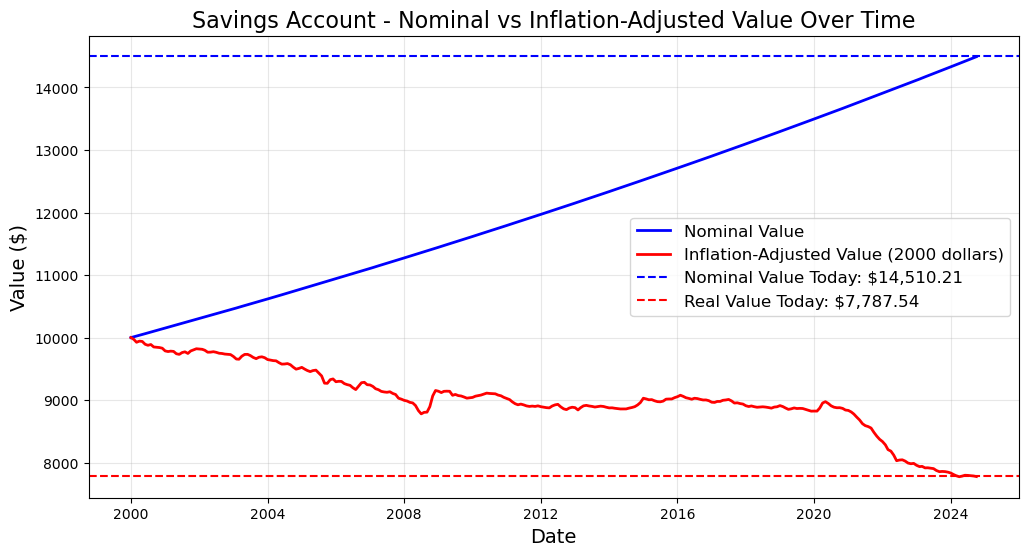

In [13]:
plt.figure(figsize=(12, 6))

plt.plot(cpi["date"], nominal_values, label="Nominal Value", color="blue", linewidth=2)
plt.plot(
    cpi["date"],
    real_values,
    label="Inflation-Adjusted Value (2000 dollars)",
    color="red",
    linewidth=2,
)

# Add horizontal lines for today's nominal and real values
plt.axhline(
    y=nominal_future_value,
    color="blue",
    linestyle="--",
    linewidth=1.5,
    label=f"Nominal Value Today: ${nominal_future_value:,.2f}",
)
plt.axhline(
    y=real_value,
    color="red",
    linestyle="--",
    linewidth=1.5,
    label=f"Real Value Today: ${real_value:,.2f}",
)

# Add labels, title, legend, and grid
plt.xlabel("Date", fontsize=14)
plt.ylabel("Value ($)", fontsize=14)
plt.title(
    "Savings Account - Nominal vs Inflation-Adjusted Value Over Time", fontsize=16
)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)

# Save the plot as a PNG file
plt.savefig("savings_account_plot.png", dpi=300)

# Display the plot
plt.show()

In [14]:
# Initialize investment
initial_investment = 10000

# Calculate nominal and real investment values
nominal_inv_10k = (merged_df["close_price"] / merged_df["close_price"].iloc[0]) * initial_investment
real_inv_10k = (merged_df["real_price"] / merged_df["real_price"].iloc[0]) * initial_investment

# Add calculated values to the merged DataFrame
merged_df["nominal_inv_10k"] = nominal_inv_10k
merged_df["real_inv_10k"] = real_inv_10k

# Get the final values
nominal_value_today = nominal_inv_10k.iloc[-1]
real_value_today = real_inv_10k.iloc[-1]

# Print the results
print(f"Nominal Value Today: ${nominal_value_today:,.2f}")
print(f"Real Value Today: ${real_value_today:,.2f}")

Nominal Value Today: $60,543.02
Real Value Today: $32,493.05


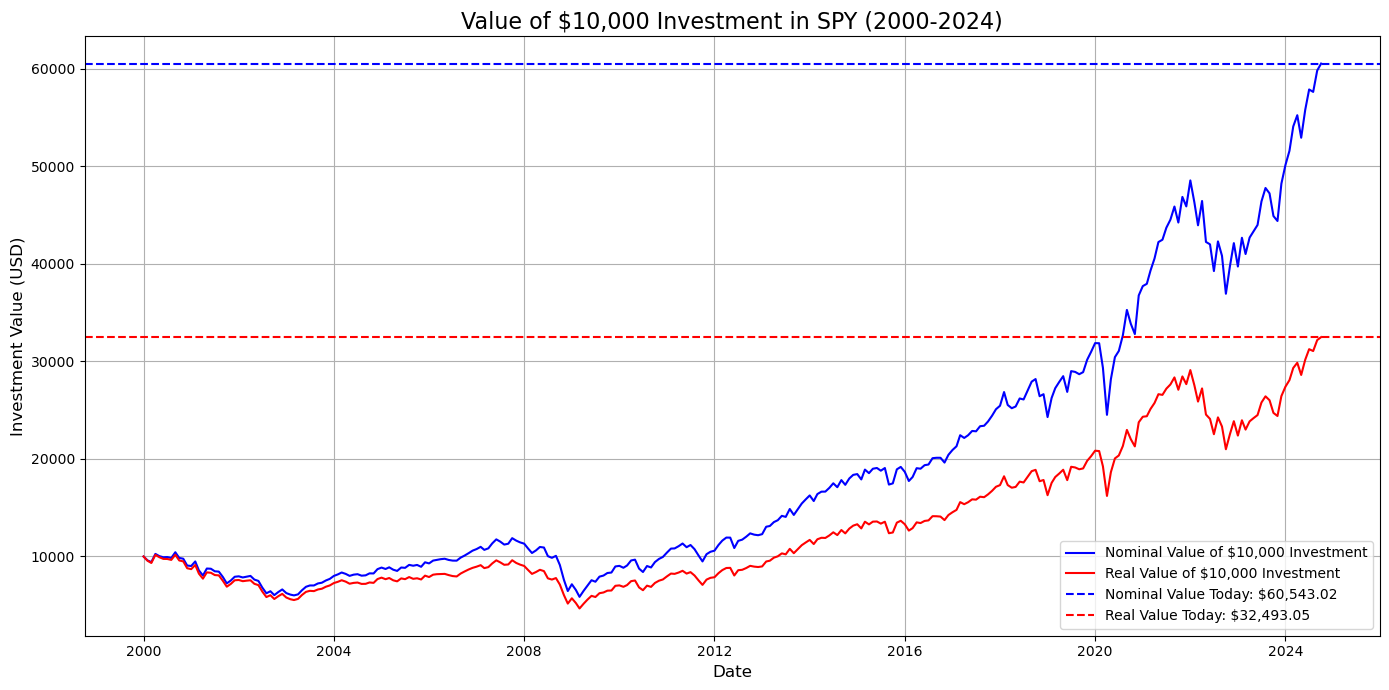

In [15]:
# Create the plot
plt.figure(figsize=(14, 7))

# Plot the investment value over time
plt.plot(
    merged_df["date"],
    merged_df["nominal_inv_10k"],
    color="blue",
    label="Nominal Value of $10,000 Investment",
)
plt.plot(
    merged_df["date"],
    merged_df["real_inv_10k"],
    color="red",
    label="Real Value of $10,000 Investment",
)

# Add horizontal lines for the final values
plt.axhline(
    y=nominal_value_today,
    color="blue",
    linestyle="--",
    linewidth=1.5,
    label=f"Nominal Value Today: ${nominal_value_today:,.2f}",
)

plt.axhline(
    y=real_value_today,
    color="red",
    linestyle="--",
    linewidth=1.5,
    label=f"Real Value Today: ${real_value_today:,.2f}",
)

# Set plot title and labels
plt.title("Value of $10,000 Investment in SPY (2000-2024)", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Investment Value (USD)", fontsize=12)
plt.legend()
plt.grid(True)

# Save and display the plot
plt.tight_layout()
plt.savefig("10k_spy.png")
plt.show()

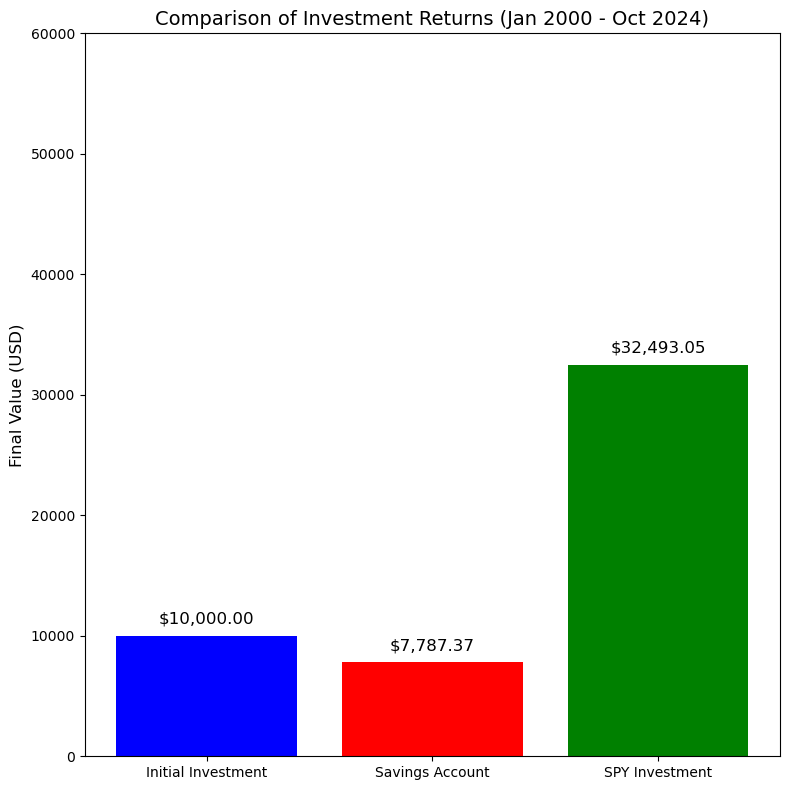

In [16]:
"""
Now given the returns from each medium, we visualise our returns
"""

spy_final_real_value = 32493.05
savings_final_real_value = 7787.37
initial_investment = 10000

categories = ["Initial Investment", "Savings Account", "SPY Investment"]
values = [initial_investment, savings_final_real_value, spy_final_real_value]

plt.figure(figsize=(8, 8))
plt.bar(categories, values, color=["blue", "red", "green"])

plt.title("Comparison of Investment Returns (Jan 2000 - Oct 2024)", fontsize=14)
plt.ylabel("Final Value (USD)", fontsize=12)
plt.ylim(0, 60000)


for i, v in enumerate(values):
    plt.text(i, v + 1000, f"${v:,.2f}", ha="center", fontsize=12)

plt.tight_layout()
plt.savefig("returns_10k.png")
plt.show()

In [17]:
# Contribution schedule
contribution_schedule = {
    "2000-01-01": 500,
    "2002-01-01": 1000,
    "2004-01-01": 1500,
    "2006-01-01": 2000,
}

# Function to determine the contribution based on the date
def get_contribution(date, schedule):
    date_obj = datetime.strptime(date, "%Y-%m-%d")
    for start_date, amount in sorted(schedule.items()):
        start_obj = datetime.strptime(start_date, "%Y-%m-%d")
        if date_obj >= start_obj:
            contribution = amount
    return contribution

# Initialize variables
balance = 10000
nominal_values = [round(balance, 2)]
monthly_rate = 1.5 / 12 / 100

# Calculate nominal and real values
for i in range(1, len(cpi)):
    date_str = cpi.loc[i, "date"].strftime("%Y-%m-%d")
    adj_fac = cpi.loc[i, "adj_fac"]

    # Calculate the monthly contribution
    contribution = get_contribution(date_str, contribution_schedule)
    
    # Update the balance with contribution and compounding
    balance += contribution
    balance *= 1 + monthly_rate
    nominal_values.append(round(balance, 2))

# Ensure real values are inflation-adjusted (divide nominal by adj_fac)
real_values = [nominal / adj for nominal, adj in zip(nominal_values, cpi["adj_fac"])]

# Create a new DataFrame with calculated values
result_df = pd.DataFrame({
    "date": cpi["date"],
    "nominal_value": nominal_values,
    "real_value": [round(real, 2) for real in real_values]
})

print(f"Final Nominal Value: ${result_df['nominal_value'].iloc[-1]:,.2f}")
print(f"Final Real Value: ${result_df['real_value'].iloc[-1]:,.2f}")

Final Nominal Value: $635,327.79
Final Real Value: $340,976.37


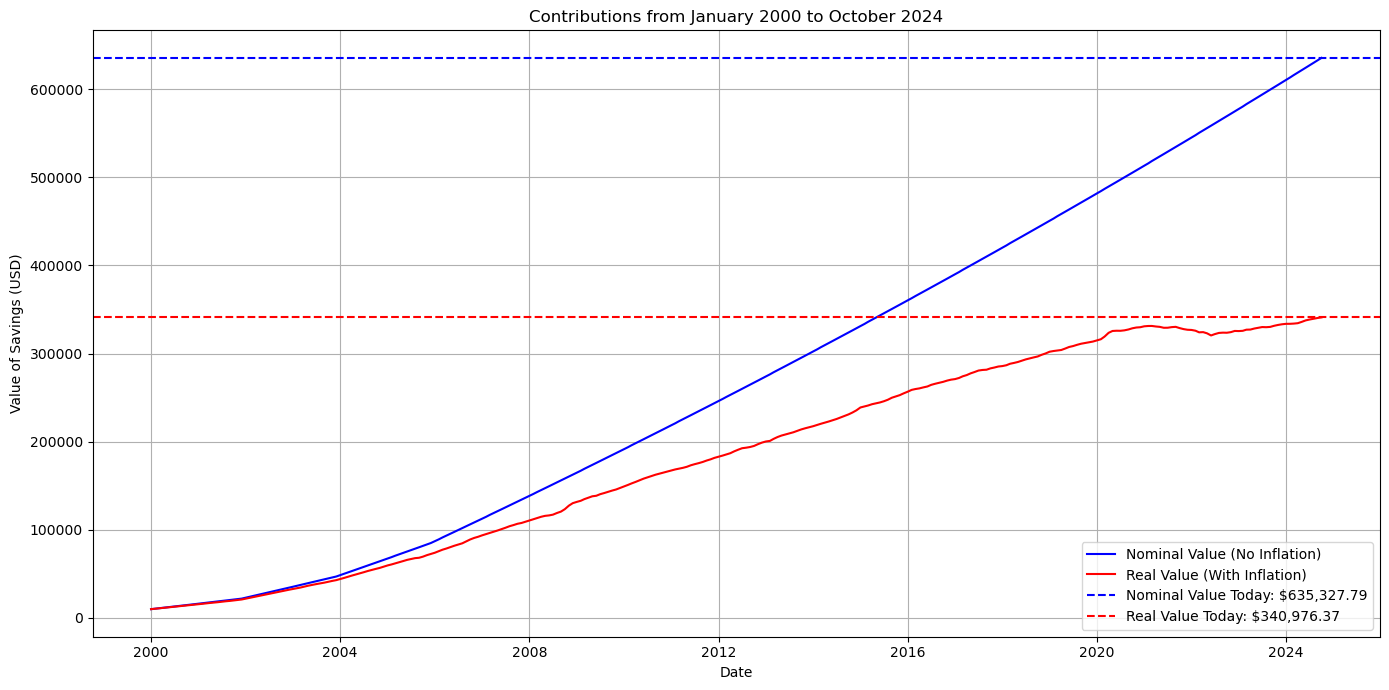

In [18]:
nominal_value_today = result_df["nominal_value"].iloc[-1]
real_value_today = result_df["real_value"].iloc[-1]

plt.figure(figsize=(14, 7))

plt.plot(
    result_df["date"],
    result_df["nominal_value"],
    color="blue",
    label="Nominal Value (No Inflation)",
)
plt.plot(
    result_df["date"],
    result_df["real_value"],
    color="red",
    label="Real Value (With Inflation)",
)

# Adding horizontal lines to highlight the current values
plt.axhline(
    y=nominal_value_today,
    color="blue",
    linestyle="--",
    linewidth=1.5,
    label=f"Nominal Value Today: ${nominal_value_today:,.2f}",
)
plt.axhline(
    y=real_value_today,
    color="red",
    linestyle="--",
    linewidth=1.5,
    label=f"Real Value Today: ${real_value_today:,.2f}",
)

# Adding legend, labels, and title
plt.legend()
plt.title("Contributions from January 2000 to October 2024")
plt.xlabel("Date")
plt.ylabel("Value of Savings (USD)")
plt.grid(True)

# Save and show the plot
plt.tight_layout()
plt.savefig("savings_comparison_diff.png")
plt.show()

In [19]:
# Initialize investment lists
invspy_nominal = [initial_investment]
invspy_real = [initial_investment]
current_contribution = 500

# Iterate through merged_df data
for i in range(1, len(merged_df)):
    # Extract current date and previous values
    date = merged_df['date'].iloc[i]
    previous_nominal = invspy_nominal[-1]
    previous_real = invspy_real[-1]
    growth_factor = merged_df['close_price'].iloc[i] / merged_df['close_price'].iloc[i - 1]
    adj_fac = merged_df['adj_fac'].iloc[i]  # Inflation adjustment factor

    # Calculate nominal value
    new_nominal = previous_nominal * growth_factor
    if date.month != merged_df['date'].iloc[i - 1].month:
        new_nominal += current_contribution  # Add monthly contribution

    # Calculate real value
    contribution_real = current_contribution / adj_fac  # Adjust contribution for inflation
    new_real = previous_real * growth_factor
    if date.month != merged_df['date'].iloc[i - 1].month:
        new_real += contribution_real  # Add inflation-adjusted contribution

    # Update monthly contribution if applicable
    for start_date, contribution in contribution_schedule.items():
        if date >= pd.to_datetime(start_date):
            current_contribution = contribution

    # Append results to the lists
    invspy_nominal.append(new_nominal)
    invspy_real.append(new_real)

# Final results
invspy_nominal_today = invspy_nominal[-1]
invspy_real_today = invspy_real[-1]

# Print results
print(f"Final Nominal Investment Value (Today): ${invspy_nominal_today:,.2f}")
print(f"Final Real Investment Value (Today): ${invspy_real_today:,.2f}")

Final Nominal Investment Value (Today): $2,321,925.94
Final Real Investment Value (Today): $1,832,571.62


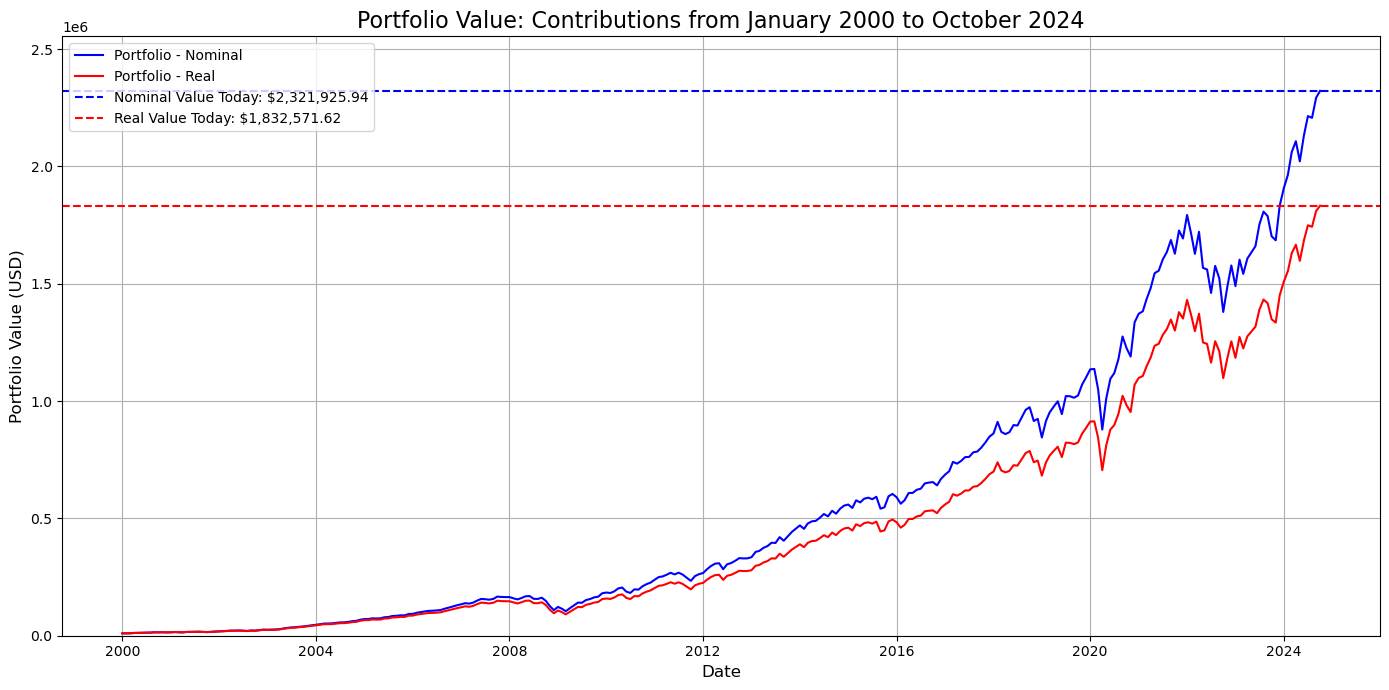

In [20]:
# Add calculated nominal and real values to merged_df
merged_df["nominal_value"] = invspy_nominal
merged_df["real_value"] = invspy_real

# Final values
nominal_value_today = merged_df["nominal_value"].iloc[-1]
real_value_today = merged_df["real_value"].iloc[-1]

# Create the plot
plt.figure(figsize=(14, 7))

# Plotting the investment values over time
plt.plot(merged_df["date"], merged_df["nominal_value"], color="blue", label="Portfolio - Nominal")
plt.plot(merged_df["date"], merged_df["real_value"], color="red", label="Portfolio - Real")

# Adding horizontal lines to highlight the current values
plt.axhline(
    y=nominal_value_today,
    color="blue",
    linestyle="--",
    linewidth=1.5,
    label=f"Nominal Value Today: ${nominal_value_today:,.2f}",
)
plt.axhline(
    y=real_value_today,
    color="red",
    linestyle="--",
    linewidth=1.5,
    label=f"Real Value Today: ${real_value_today:,.2f}",
)

# Adding legend, labels, and title
plt.legend(loc="upper left", fontsize=10)
plt.ylim(0, max(nominal_value_today, real_value_today) * 1.1)  # Dynamically set y-axis range
plt.title("Portfolio Value: Contributions from January 2000 to October 2024", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Portfolio Value (USD)", fontsize=12)
plt.grid(True)

# Save and show the plot
plt.tight_layout()
plt.savefig("spy_comparison_diff.png")
plt.show()

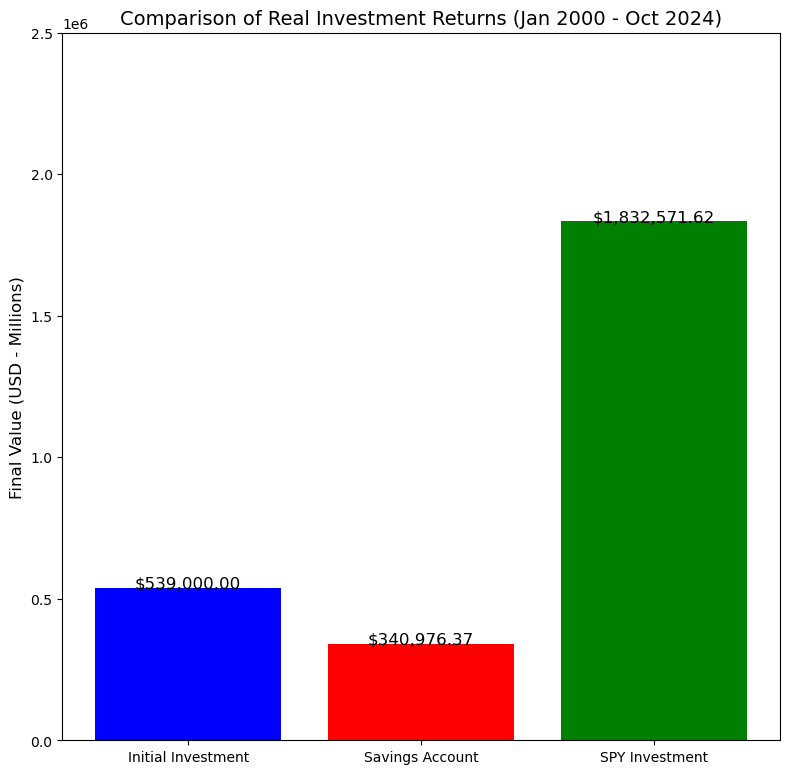

In [21]:
pf_final_real_value = 1832571.62
savings_final_real_value = 340976.37
total_investment = 539000

categories = ["Initial Investment", "Savings Account", "SPY Investment"]
values = [total_investment, savings_final_real_value, pf_final_real_value]

plt.figure(figsize=(8, 8))
plt.bar(categories, values, color=["blue", "red", "green"])

plt.title("Comparison of Real Investment Returns (Jan 2000 - Oct 2024)", fontsize=14)
plt.ylabel("Final Value (USD - Millions)", fontsize=12)
plt.ylim(0,2500000)

for i, v in enumerate(values):
    plt.text(i, v + 1000, f"${v:,.2f}", ha="center", fontsize=12)

plt.tight_layout()
plt.savefig("part-1.2-fig-6.2.png")
plt.show()

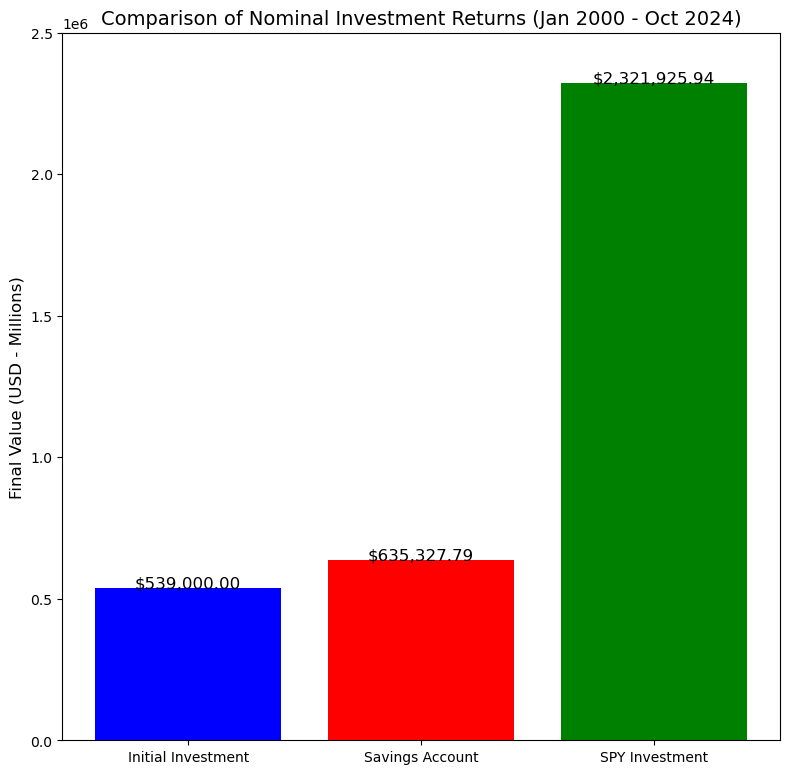

In [22]:
pf_final_nom_value = 2321925.94
savings_final_nom_value = 635327.79

categories = ["Initial Investment", "Savings Account", "SPY Investment"]
values = [total_investment, savings_final_nom_value,pf_final_nom_value]

plt.figure(figsize=(8, 8))
plt.bar(categories, values, color=["blue", "red", "green"])

plt.title("Comparison of Nominal Investment Returns (Jan 2000 - Oct 2024)", fontsize=14)
plt.ylabel("Final Value (USD - Millions)", fontsize=12)
plt.ylim(0,2500000)

for i, v in enumerate(values):
    plt.text(i, v + 1000, f"${v:,.2f}", ha="center", fontsize=12)

plt.tight_layout()
plt.savefig("part-1.2-fig-6.1.png")
plt.show()